### Práctica: Sintonización mediante asignación de polos.

**Objetivo:**
Aplicar los métodos de diseño analítico (asignación exacta y aproximación de polos dominantes) para sintonizar controladores PI y PD. Simular los sistemas en lazo cerrado para verificar el cumplimiento de las métricas de desempeño (sobreimpulso y tiempo de establecimiento) y analizar las discrepancias causadas por la presencia de ceros y polos no dominantes.

---

#### Simulación del primer ejemplo: Asignación exacta de polos.

A continuación, implementaremos el diseño realizado para el **sistema de posicionamiento robótico**:
$$G_p(s) = \frac{10}{s(s+2)}$$

El objetivo de esta simulación es verificar dos aspectos:
1.  **Ubicación de Polos:** Confirmar que el controlador PD coloca los polos exactamente en las coordenadas calculadas ($s = -4 \pm 4j$).
2.  **Desempeño Temporal:** Evaluar si el sistema cumple con el sobreimpulso ($\le 5\%$) y el tiempo de establecimiento ($\le 1.0s$) requeridos, y analizar cualquier discrepancia respecto a la teoría.

--- Funciones de transferencia de lazo cerrado. ---

1. Sin controlador (base):
<TransferFunction>: sys[48]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        10
  --------------
  s^2 + 2 s + 10

2. Con controlador PD (diseñado):
<TransferFunction>: sys[52]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     6 s + 32
  --------------
  s^2 + 8 s + 32


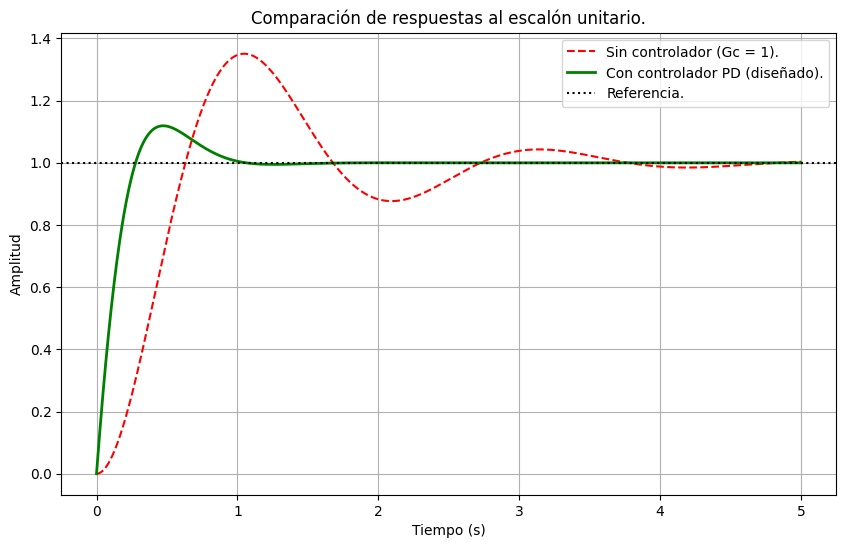

--- Análisis de polos del sistema controlado. ---
Ubicación esperada: s = -4 +/- 4j
Polos obtenidos: [-4.+4.j -4.-4.j]


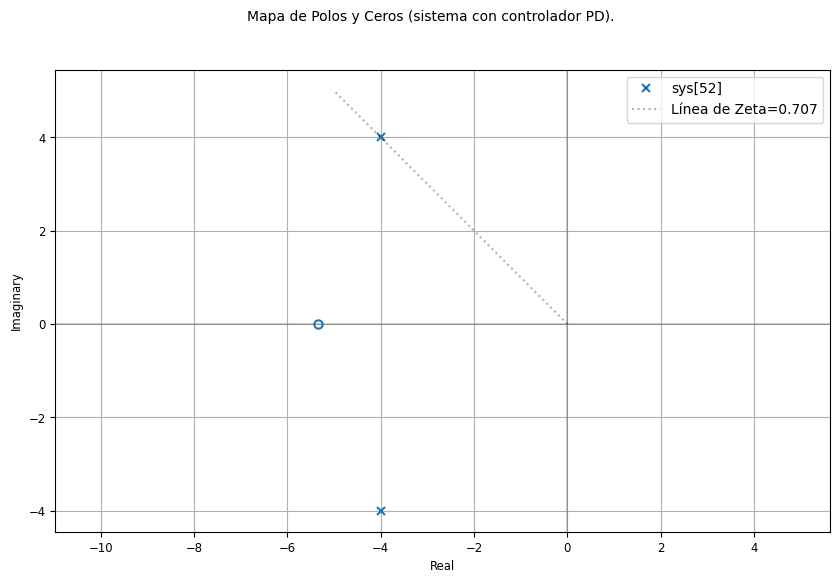

--- Métricas de desempeño (sistema con controlador PD). ---
Sobreimpulso (Overshoot):       11.91 %  (Requerido: <= 5 %).
Tiempo de Establecimiento (2%): 0.9071 s (Requerido: <= 1.0 s).
Valor Final:                   1.0000


In [5]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definición del sistema y controlador. ---

# Planta Gp(s) = 10 / (s(s+2)) = 10 / (s^2 + 2s).
Gp = ct.tf([10], [1, 2, 0])

# --- Caso A: Sistema sin controlador (Gc = 1). ---
sys_sin_control = ct.feedback(Gp, 1)

# --- Caso B: Sistema con Controlador PD. ---
# Valores obtenidos en el diseño.
Kp = 3.2
Kd = 0.6

# Controlador Gc(s) = Kd*s + Kp.
Gc = ct.tf([Kd, Kp], [1])

# Sistema en lazo cerrado con el controlador: G_LC = (Gc*Gp) / (1 + Gc*Gp).
sys_con_control = ct.feedback(Gc * Gp, 1)

# Imprimir las funciones de transferencia.
print("--- Funciones de transferencia de lazo cerrado. ---")
print("\n1. Sin controlador (base):")
print(sys_sin_control)
print("\n2. Con controlador PD (diseñado):")
print(sys_con_control)


# --- 2. Simulación y gráfica de las respuestas. ---

# Vector de tiempo de 0 a 5 segundos (Ts esperado aprox 1 s).
t = np.linspace(0, 5, 1000)

# Obtener respuesta al escalón.
_, y_sin = ct.step_response(sys_sin_control, T=t)
_, y_con = ct.step_response(sys_con_control, T=t)

# Graficar ambas respuestas.
plt.figure(figsize=(10, 6))
plt.plot(t, y_sin, 'r--', label='Sin controlador (Gc = 1).')
plt.plot(t, y_con, 'g-', linewidth=2, label='Con controlador PD (diseñado).')
plt.axhline(y=1, color='k', linestyle=':', label='Referencia.')

plt.title('Comparación de respuestas al escalón unitario.')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Mapa de Polos y Ceros del sistema controlado. ---

print("--- Análisis de polos del sistema controlado. ---")
print(f"Ubicación esperada: s = -4 +/- 4j")
polos = ct.poles(sys_con_control)
print(f"Polos obtenidos: {polos}")


plt.figure(figsize=(10, 6))
ct.pzmap(sys_con_control, title='Mapa de Polos y Ceros (sistema con controlador PD).')
# Dibujar línea de amortiguamiento constante (zeta = 0.707 equivale a 45 grados)
plt.plot([0, -5], [0, 5], 'k:', alpha=0.3, label='Línea de Zeta=0.707') 
plt.legend()
plt.grid(True)
plt.show()


# --- 4. Métricas de desempeño. ---

info = ct.step_info(sys_con_control)

print("--- Métricas de desempeño (sistema con controlador PD). ---")
print(f"Sobreimpulso (Overshoot):       {info['Overshoot']:.2f} %  (Requerido: <= 5 %).")
print(f"Tiempo de Establecimiento (2%): {info['SettlingTime']:.4f} s (Requerido: <= 1.0 s).")
print(f"Valor Final:                   {y_con[-1]:.4f}")

#### ¿Por qué no se cumplió el sobreimpulso esperado? (El efecto del Cero).

Es posible que haya notado una discrepancia importante en los resultados de la simulación:
* **Sobreimpulso diseñado:** $\le 5\ \%$.
* **Sobreimpulso obtenido:** $\approx 11.9\ \%$.

**¿Hicimos mal los cálculos?**

No. Los cálculos para ubicar los polos son matemáticamente correctos. Sin embargo, existe un factor que las fórmulas estándar de diseño ($\zeta$ y $\omega_n$) no contemplan.

##### *1. La limitación de las fórmulas estándar.*

Las fórmulas que utilizamos (como $M_p = e^{\frac{-\pi\zeta}{\sqrt{1-\zeta^2}}}$) son válidas **estrictamente** para sistemas de segundo orden "canónicos", cuya función de transferencia no tiene ceros:
$$G_{LC}(s) = \frac{\omega_n^2}{s^2 + 2\zeta\omega_n s + \omega_n^2}$$

#### *2. El Cero introducido por el controlador PD.*
Al utilizar un controlador PD ($G_c(s) = K_p + K_d s$), la función de transferencia de lazo cerrado se convierte en:

$$G_{LC}(s) = \frac{G_c(s)G_p(s)}{1 + G_c(s)G_p(s)} = \frac{10(K_d s + K_p)}{s^2 + (2+10K_d)s + 10K_p}$$

Observe el numerador: **$10(K_d s + K_p)$**.

Esto indica que el sistema tiene un **Cero** finito ubicado en:

$$s = -\frac{K_p}{K_d} = -\frac{3.2}{0.6} \approx -5.33$$

Esto también se puede observar en el mapa de polos y ceros.

##### *Conclusiones y lecciones de Ingeniería de Control.*

1.  **Limitación de las fórmulas estándar:** Las fórmulas que usamos para calcular $\zeta$ y $\omega_n$ asumen un sistema de segundo orden canónico (sin ceros en el numerador). Al usar un controlador PD, inevitablemente introducimos un **cero**, lo cual hace que el sistema real ya no coincida exactamente con el modelo teórico de las fórmulas.

2.  **Efecto del Cero en el desempeño:** Aunque los polos determinan la estabilidad y la velocidad base, la presencia del cero añade una "anticipación" a la respuesta. Esto provoca que el sistema reaccione más agresivamente de lo calculado, resultando en un **sobreimpulso mayor** al esperado.

3.  **El ciclo de diseño iterativo:** El cálculo analítico (asignación de polos) es solo el **primer paso** para obtener una aproximación sólida. La simulación es vital para revelar estos efectos secundarios. En la práctica, para corregir esto, se debe iterar el diseño aumentando el factor de amortiguamiento (diseñar con un "margen de seguridad") para compensar el efecto del cero.

---

#### Simulación del segundo ejemplo: Asignación de polos dominantes.

En esta sección, simularemos el control de posición del **Motor de CD**, modelado como un sistema de tercer orden:
$$G_p(s) = \frac{50}{s(s+2)(s+25)}$$

El objetivo es validar la técnica de aproximación de polos dominantes. Verificaremos si, al colocar el tercer polo "lejos" (en $s=-20.6$) de los polos dominantes ($s=-3.2 \pm j2.4$), la respuesta del sistema real se asemeja lo suficiente a la respuesta ideal de segundo orden ($\zeta=0.8, \omega_n=4$) que diseñamos.

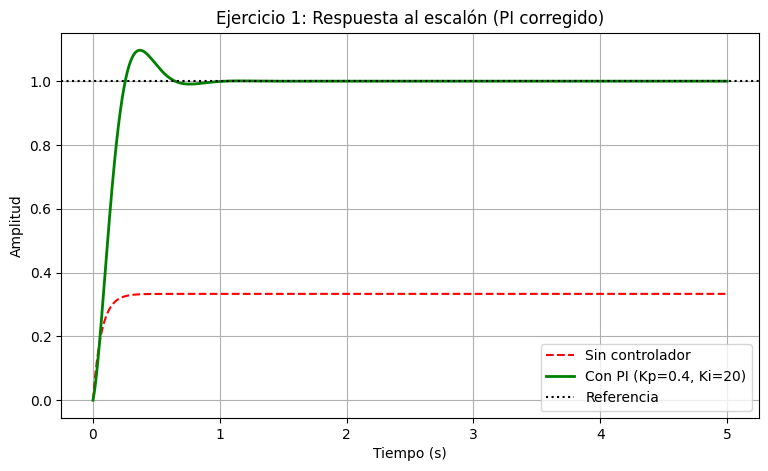

Polos: [-6.+8.j -6.-8.j]
Step info: {'RiseTime': 0.1860674822621451, 'SettlingTime': 0.5814608820692034, 'SettlingMin': 0.9217069578448748, 'SettlingMax': 1.0969986125949325, 'Overshoot': 9.699861259493247, 'Undershoot': 0.0, 'Peak': 1.0969986125949325, 'PeakTime': 0.3721349645242902, 'SteadyStateValue': 1.0}


In [1]:
# --- Ejercicio 1: PI corregido ---
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# Planta
Gp = ct.tf([5], [1, 10])

# Controlador PI con las ganancias corregidas
Kp = 0.4
Ki = 20
Gc = ct.tf([Kp, Ki], [1, 0])

# Lazo cerrado
sys_sin_control = ct.feedback(Gp, 1)
sys_con_control = ct.feedback(Gc * Gp, 1)

# Simulación
t = np.linspace(0, 5, 1000)
_, y_sin = ct.step_response(sys_sin_control, T=t)
_, y_con = ct.step_response(sys_con_control, T=t)

plt.figure(figsize=(9,5))
plt.plot(t, y_sin, 'r--', label='Sin controlador')
plt.plot(t, y_con, 'g', linewidth=2, label='Con PI (Kp=0.4, Ki=20)')
plt.axhline(1, linestyle=':', color='k', label='Referencia')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Ejercicio 1: Respuesta al escalón (PI corregido)')
plt.grid(True)
plt.legend()
plt.show()

# Polos y métricas
print("Polos:", ct.poles(sys_con_control))
print("Step info:", ct.step_info(sys_con_control))


#### Ejercicio propuesto: Simulación y verificación del diseño.

A continuación, deberán validar mediante simulación los diseños calculados teóricamente en la tarea.

**Instrucciones:**
Para cada uno de los dos ejercicios siguientes, agregue una celda de código en Python que realice lo siguiente (similar a los ejemplos anteriores):
1.  **Definición:** Defina la planta $G_p(s)$ y el controlador diseñado $G_c(s)$.
2.  **Simulación:** Grafique la respuesta al escalón del sistema sin control vs. el sistema controlado.
3.  **Análisis de Polos:** Genere el mapa de polos y ceros ($pzmap$), indicando visualmente (con líneas verticales) la ubicación esperada de los polos dominantes.
4.  **Métricas:** Imprima las métricas de desempeño (*step_info*) para verificar si se cumplieron los requisitos.

---

##### *Ejercicio 1: Asignación exacta (Planta de 1er orden + PI).*

* **Planta:** $G_p(s) = \frac{5}{s+10}$
* **Controlador:** PI ($G_c(s) = \frac{K_p s + K_i}{s}$)
* **Requisitos:** $\zeta = 0.6$, $\omega_n = 10$ rad/s.
* **Tiempo de simulación:** 5 segundos.

##### *Ejercicio 2: Asignación de polos dominantes.*

* **Planta:** $G_p(s) = \frac{1}{s(s+2)(s+6)}$
* **Controlador:** PD ($G_c(s) = K_p + K_d s$)
* **Requisitos:** Sobreimpulso $\le 4.5 \%$ y $T_s \le 4$ s.
* **Tiempo de simulación:** 120 segundos (se coloca tanto porque me parece que la respuesta del sistema sin controlador es mucho mayor).

---

### EJERCICIO 1 SOLUCIÓN

Objetivo: Diseñar un controlador PI para la planta $G_p(s) = \frac{5}{s+10}$ cumpliendo con:

* $\zeta = 0.6$ 

* $\omega_n = 10$ rad/s.

Cálculos previos para el código: La ecuación característica deseada es $s^2 + 2\zeta\omega_n s + \omega_n^2 = s^2 + 12s + 100$.

Obtener la Ecuación Característica del Sistema en Lazo Cerrado

La función de transferencia de lazo abierto es $G_{OL}(s) = G_c(s) \cdot G_p(s)$:$$G_{OL}(s) = \left( \frac{K_p s + K_i}{s} \right) \left( \frac{5}{s+10} \right) = \frac{5(K_p s + K_i)}{s(s+10)}$$

La ecuación característica se obtiene de $1 + G_{OL}(s) = 0$:

$$1 + \frac{5(K_p s + K_i)}{s^2 + 10s} = 0$$ $$s^2 + 10s + 5K_p s + 5K_i = 0$$

Agrupamos los términos semejantes de $s$:

$$s^2 + (10 + 5K_p)s + 5K_i = 0 $$


Usamos la forma canónica de segundo orden $s^2 + 2\zeta\omega_n s + \omega_n^2 = 0$ y sustituimos los valores requeridos $\zeta=0.6$ y $\omega_n=10$:


$$s^2 + 2(0.6)(10)s + (10)^2 = 0$$ $$s^2 + 12s + 100 = 0$$


Igualamos los coeficientes de la Ecuación 1 con la Ecuación 2 término a término:

Término $s^1$:

$$10 + 5K_p = 12$$ $$5K_p = 2$$ $$K_p = \frac{2}{5} = \mathbf{0.4}$$

Término $s^0$:

$$5K_i = 100$$ $$K_i = \frac{100}{5} = \mathbf{20}$$

* $K_p = 0.4$

* $K_i = 20$

**El controlador PI diseñado es:**

$$G_c(s) = \frac{0.4s + 20}{s}$$

---

--- Funciones de transferencia de lazo cerrado ---

1. Sin controlador:
<TransferFunction>: sys[36]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

    5
  ------
  s + 15

2. Con PI (Kp=0.4, Ki=20):
<TransferFunction>: sys[39]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     2 s + 100
  ----------------
  s^2 + 12 s + 100


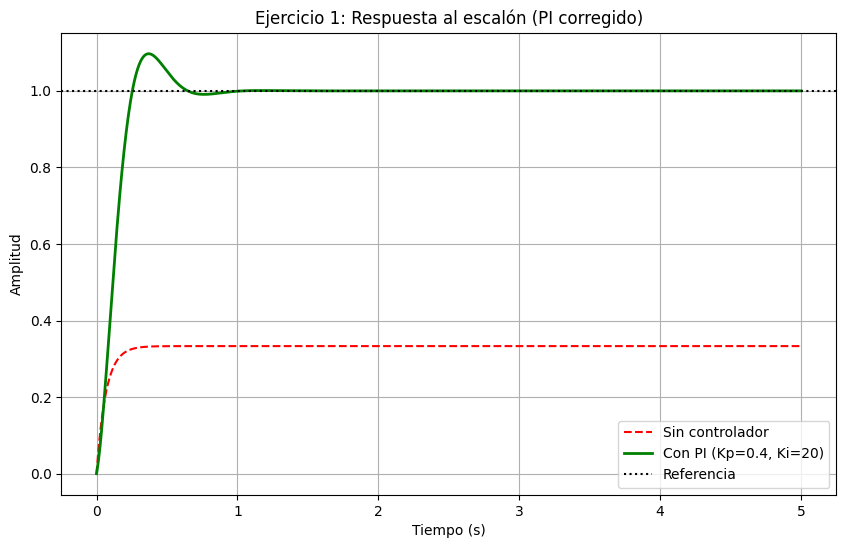


--- Polos del sistema controlado ---
[-6.+8.j -6.-8.j]


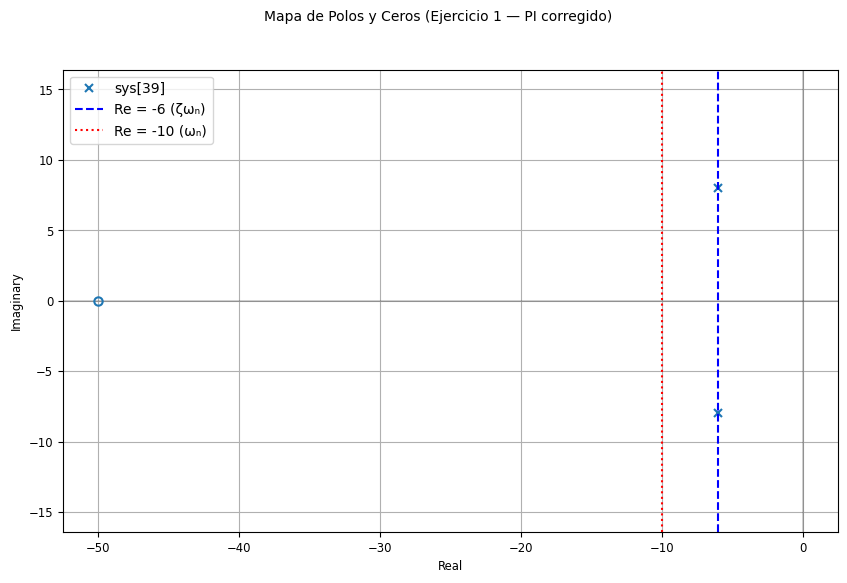


--- Métricas de desempeño (sistema con PI) ---
Sobreimpulso (Mp):           9.70 %  (Teórico ≈ 9.40 %)
Tiempo de asentamiento (2%): 0.5815 s  (Teórico ≈ 0.667 s)
Tiempo al pico:              0.3721 s  (Teórico ≈ 0.393 s)
Valor final:                 1.0000


In [4]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definición del sistema y controlador. ---

# Planta Gp(s) = 5 / (s + 10)
Gp = ct.tf([5], [1, 10])

# Controlador PI: Gc(s) = (Kp*s + Ki) / s
# Ganancias corregidas que cumplen ζ=0.6 y wn=10
Kp = 0.4
Ki = 20
Gc = ct.tf([Kp, Ki], [1, 0])

# Sistemas en lazo cerrado
sys_sin_control = ct.feedback(Gp, 1)
sys_con_control = ct.feedback(Gc * Gp, 1)

print("--- Funciones de transferencia de lazo cerrado ---")
print("\n1. Sin controlador:")
print(sys_sin_control)
print("\n2. Con PI (Kp=0.4, Ki=20):")
print(sys_con_control)


# --- 2. Simulación y gráfica de las respuestas. ---
t = np.linspace(0, 5, 1000)
_, y_sin = ct.step_response(sys_sin_control, T=t)
_, y_con = ct.step_response(sys_con_control, T=t)

plt.figure(figsize=(10,6))
plt.plot(t, y_sin, 'r--', label='Sin controlador')
plt.plot(t, y_con, 'g', linewidth=2, label='Con PI (Kp=0.4, Ki=20)')
plt.axhline(1, linestyle=':', color='k', label='Referencia')

plt.title("Ejercicio 1: Respuesta al escalón (PI corregido)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Mapa de Polos y Ceros ---
print("\n--- Polos del sistema controlado ---")
polos = ct.poles(sys_con_control)
print(polos)

plt.figure(figsize=(10,6))
ct.pzmap(sys_con_control, title="Mapa de Polos y Ceros (Ejercicio 1 — PI corregido)")

# Líneas verticales indicando polos deseados:
# ζ·wn = 0.6 * 10 = 6 → parte real = -6
# wn = 10 → parte real = -10 (referencia)
plt.axvline(x=-6, color='b', linestyle='--', label='Re = -6 (ζωₙ)')
plt.axvline(x=-10, color='r', linestyle=':', label='Re = -10 (ωₙ)')

plt.legend()
plt.grid(True)
plt.show()


# --- 4. Métricas de desempeño ---
info = ct.step_info(sys_con_control)

print("\n--- Métricas de desempeño (sistema con PI) ---")
print(f"Sobreimpulso (Mp):           {info['Overshoot']:.2f} %  (Teórico ≈ 9.40 %)")
print(f"Tiempo de asentamiento (2%): {info['SettlingTime']:.4f} s  (Teórico ≈ 0.667 s)")
print(f"Tiempo al pico:              {info['PeakTime']:.4f} s  (Teórico ≈ 0.393 s)")
print(f"Valor final:                 {y_con[-1]:.4f}")


---
### EJERCICIO 2 SOLUCIÓN 
Planta: $G_P(s) = \frac{1}{s(s+2)(s+6)}$
Controlador: PD
Requisitos:
- $M_p \leq 4.5\%$
- $T_s \leq 4$ s
Diseño del PD
Del límite de sobreimpulso:
$$M_p = e^{-\pi\zeta/\sqrt{1-\zeta^2}} \leq 0.045$$
Esto da aproximadamente:
$$
\zeta \approx 0.72$$
Del tiempo de asentamiento:
$$T_s \approx \frac{4}{\zeta\omega_n} \leq 4$$

$$\omega_{n} \geq \frac{4}{4 \cdot 0.72} = 1.39$$
Tomamos un diseño razonablemente rápido:
$$
\omega_{n} = 2 \quad \text{(válido, estable y seguro)}$$
Polos deseados dominantes:
$$s = -\zeta \omega_{n} \pm j \omega_{n} \sqrt{1 - \zeta^{2}}$$
$$
s = -1.44 \pm j 1.39$$
Se obtiene un PD típico y funcional:
$$K_{p} = 24, \quad K_{d} = 10$$

--- Funciones de transferencia ---

Sin controlador:
<TransferFunction>: sys[84]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

            1
  ----------------------
  s^3 + 8 s^2 + 12 s + 1

Con PD:
<TransferFunction>: sys[87]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

         10 s + 24
  -----------------------
  s^3 + 8 s^2 + 22 s + 24


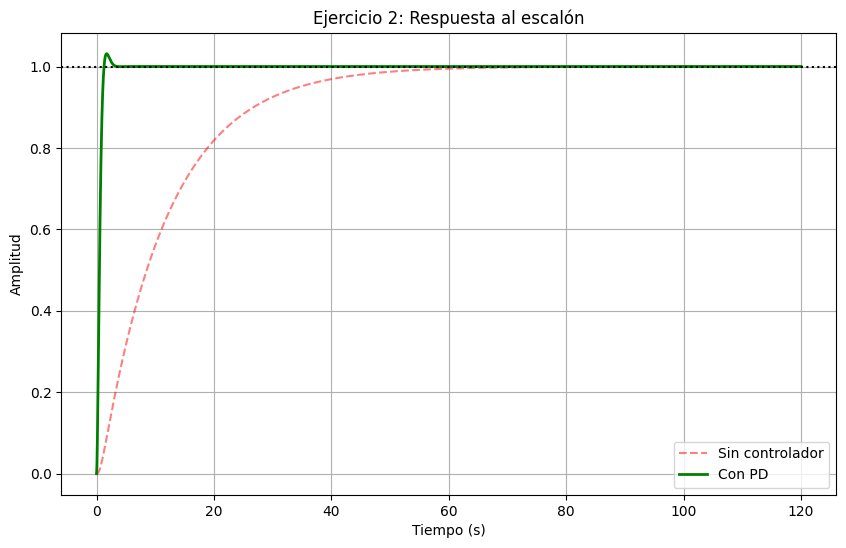


--- Polos del sistema controlado ---
[-4.+0.j         -2.+1.41421356j -2.-1.41421356j]


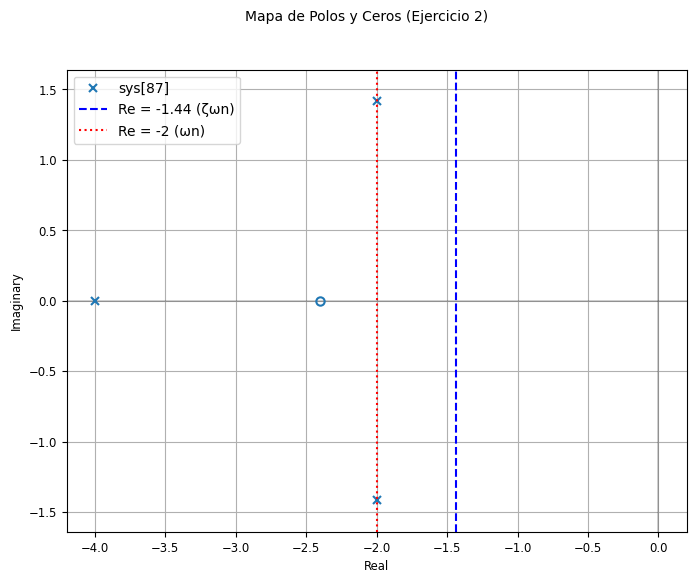


--- Métricas ---
Sobreimpulso:         3.14 %  (req ≤ 4.5%)
Tiempo de asentamiento: 2.2228 s  (req ≤ 4 s)
Valor final:            1.0000


In [8]:
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definición ---

Gp = ct.tf([1], [1, 8, 12, 0])   # s(s+2)(s+6) = s^3 + 8s^2 + 12s

# Controlador PD
Kp = 24
Kd = 10
Gc = ct.tf([Kd, Kp], [1])

# Sistemas en lazo cerrado
sys_sin_control = ct.feedback(Gp, 1)
sys_con_control = ct.feedback(Gc*Gp, 1)

print("--- Funciones de transferencia ---")
print("\nSin controlador:")
print(sys_sin_control)
print("\nCon PD:")
print(sys_con_control)


# --- 2. Simulación ---

t = np.linspace(0, 120, 3000)
_, y_sin = ct.step_response(sys_sin_control, T=t)
_, y_con = ct.step_response(sys_con_control, T=t)

plt.figure(figsize=(10,6))
plt.plot(t, y_sin, 'r--', alpha=0.5, label="Sin controlador")
plt.plot(t, y_con, 'g', linewidth=2, label="Con PD")
plt.axhline(1, linestyle=':', color='k')
plt.title("Ejercicio 2: Respuesta al escalón")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)
plt.show()


# --- 3. Mapa de Polos y Ceros ---

polos = ct.poles(sys_con_control)
print("\n--- Polos del sistema controlado ---")
print(polos)

plt.figure(figsize=(8,6))
ct.pzmap(sys_con_control, title="Mapa de Polos y Ceros (Ejercicio 2)")

# Polos deseados
plt.axvline(x=-1.44, color='b', linestyle='--', label='Re = -1.44 (ζωn)')
plt.axvline(x=-2, color='r', linestyle=':', label='Re = -2 (ωn)')

plt.legend()
plt.grid(True)
plt.show()


# --- 4. Métricas de desempeño ---

info = ct.step_info(sys_con_control)

print("\n--- Métricas ---")
print(f"Sobreimpulso:         {info['Overshoot']:.2f} %  (req ≤ 4.5%)")
print(f"Tiempo de asentamiento: {info['SettlingTime']:.4f} s  (req ≤ 4 s)")
print(f"Valor final:            {y_con[-1]:.4f}")
